In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass, field
import yfinance as yf
import os

# ML Libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import joblib


# the class I use to keep simulation data
@dataclass
class OptionSymbolData:
    """
    Data class to store all relevant data for an option symbol.
    """
    symbol: str
    # Simulation Data
    sim_moneyness: list = field(default_factory=list)            # List of moneyness arrays
    sim_time_to_maturity: list = field(default_factory=list)     # List of time arrays
    sim_option_prices: list = field(default_factory=list)        # List of option price arrays
    sim_residuals_future: list = field(default_factory=list)     # List of future residuals tuples
    # Real Market Data
    market_moneyness: np.ndarray = field(default=None)           # Array of market moneyness
    market_time_to_maturity: np.ndarray = field(default=None)    # Array of market time to maturity
    market_option_prices: np.ndarray = field(default=None)       # Array of market option prices
    BSM_prices: np.ndarray = field(default=None)                 # Array of BSM predicted prices
    # Residuals
    residuals_past: tuple = None                                 # Tuple of past residuals (time, residuals)
    residuals_past_moneyness: np.ndarray = field(default=None)   # Array of moneyness corresponding to residuals_past
    
    # ----- New Attributes for Modeling ----- #
    model: object = None                                         # Trained regression model
    X_train: np.ndarray = None                                   # Training features
    X_val: np.ndarray = None                                     # Validation features
    y_train: np.ndarray = None                                   # Training targets
    y_val: np.ndarray = None                                     # Validation targets
    y_val_pred: np.ndarray = None                                # Validation predictions
    mse: float = None                                            # Mean Squared Error on validation
    r2: float = None                                             # R² Score on validation

In [18]:
# Functions for Black Scholes pricing and to simulate stock prices with geometric brownian motion

def black_scholes_vectorized(S, K, T, r, sigma, is_call):
    """
    Calculate Black-Scholes option prices for calls and puts.

    Parameters:
        S (np.ndarray): Stock price paths.
        K (float): Strike price.
        T (np.ndarray): Time to maturity.
        r (float): Risk-free rate.
        sigma (float): Volatility.
        is_call (bool): True for call options, False for puts.

    Returns:
        np.ndarray: Option prices.
    """
    T = np.maximum(T, 1e-8)  # Avoid division by zero
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_prices = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put_prices = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return np.where(is_call, call_prices, put_prices)

def simulate_gbm(S0, T, r, sigma, n_steps, n_paths):
    """
    Simulate Geometric Brownian Motion paths.

    Parameters:
        S0 (float): Initial stock price.
        T (float): Time to maturity.
        r (float): Risk-free rate.
        sigma (float): Volatility.
        n_steps (int): Number of time steps.
        n_paths (int): Number of simulation paths.

    Returns:
        np.ndarray: Simulated stock price paths.
    """
    dt = T / n_steps
    paths = np.zeros((n_steps + 1, n_paths))
    paths[0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

In [19]:
# Functions to process data

def get_top_symbols(data, top_n=3):
    """
    Retrieve the top N symbols based on trading volume.

    Parameters:
        data (pd.DataFrame): Filtered data containing option information.
        top_n (int): Number of top symbols to retrieve.

    Returns:
        list: List of top symbol names.
    """
    top_symbols = data.groupby("symbol")["volume"].sum().nlargest(top_n).index.tolist()
    return top_symbols

def load_and_preprocess_data(filepath):
    """
    Load and preprocess the option data from a CSV file.

    Parameters:
        filepath (str): Path to the CSV file containing the data.

    Returns:
        pd.DataFrame: Preprocessed DataFrame ready for analysis.
    """
    # Load dataset
    filtered_data = pd.read_csv(filepath)

    # Convert dates to datetime
    filtered_data['date'] = pd.to_datetime(filtered_data['date'], errors='coerce')
    filtered_data['exdate'] = pd.to_datetime(filtered_data['exdate'], errors='coerce')
    filtered_data['date'] = filtered_data['date'].dt.tz_localize(None)

    # Fetch stock prices
    start_date = filtered_data['date'].min().strftime('%Y-%m-%d')
    end_date = filtered_data['date'].max().strftime('%Y-%m-%d')

    print(f"Fetching stock prices from {start_date} to {end_date}...")
    stock_prices = {}
    for ticker in filtered_data['ticker'].unique():
        try:
            data = yf.Ticker(ticker).history(start=start_date, end=end_date)
            if not data.empty:
                stock_prices[ticker] = data['Close']
            else:
                print(f"No data for {ticker}.")
        except Exception as e:
            print(f"Failed to fetch data for {ticker}: {e}")

    stock_prices_df = pd.DataFrame(stock_prices).reset_index()
    stock_prices_df = stock_prices_df.melt(id_vars='Date', var_name='ticker', value_name='Stock_Price')
    stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date']).dt.tz_localize(None)

    # Merge with filtered data
    filtered_data = pd.merge(
        filtered_data,
        stock_prices_df,
        left_on=['date', 'ticker'],
        right_on=['Date', 'ticker'],
        how='left'
    )
    filtered_data.drop(columns=['Date'], inplace=True)

    # Adjust and calculate additional fields
    filtered_data['strike_price'] = filtered_data['strike_price'] / 1000
    filtered_data['market_price'] = (filtered_data['best_bid'] + filtered_data['best_offer']) / 2
    filtered_data['time_to_maturity'] = (filtered_data['exdate'] - filtered_data['date']).dt.days / 365
    filtered_data = filtered_data[filtered_data['time_to_maturity'] > 0]
    filtered_data['moneyness'] = filtered_data['Stock_Price'] / filtered_data['strike_price']

    # Fetch risk-free rate
    print("Fetching 10-year Treasury yields (TNX)...")
    try:
        tnx_data = yf.Ticker("^TNX").history(start=start_date, end=end_date)
        tnx_data['date'] = tnx_data.index.tz_localize(None)
        tnx_data = tnx_data[['Close']].rename(columns={'Close': 'TNX_Yield'})
        tnx_data.reset_index(inplace=True)
        tnx_data.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], errors='ignore', inplace=True)
        tnx_data['date'] = pd.to_datetime(tnx_data['Date']).dt.tz_localize(None)
        tnx_data.drop(columns=['Date'], inplace=True, errors='ignore')
        filtered_data = pd.merge(filtered_data, tnx_data, on='date', how='left')
        filtered_data['risk_free_rate'] = filtered_data['TNX_Yield'] / 100
    except Exception as e:
        print(f"Failed to fetch TNX: {e}")
        filtered_data['risk_free_rate'] = 0.02  # Default risk-free rate

    # Fill any remaining missing risk-free rates with default value
    filtered_data['risk_free_rate'].fillna(0.02, inplace=True)

    # Handle missing values in essential columns
    essential_cols = ['Stock_Price', 'strike_price', 'best_bid', 'best_offer', 'impl_volatility', 'cp_flag']
    filtered_data.dropna(subset=essential_cols, inplace=True)

    # Return the preprocessed data
    return filtered_data

def process_symbol(symbol, data, thresholds, simulation_params):
    """
    Process data for a single symbol: simulate GBM, calculate option prices, and compute residuals.

    Parameters:
        symbol (str): The option symbol to process.
        data (pd.DataFrame): DataFrame containing data for the symbol.
        thresholds (np.ndarray): Array of threshold values.
        simulation_params (dict): Dictionary of simulation parameters.

    Returns:
        OptionSymbolData: An instance containing all processed data for the symbol.
    """
    n_steps = simulation_params['n_steps']
    n_paths = simulation_params['n_paths']
    early_fraction = simulation_params['early_fraction']

    symbol_data = OptionSymbolData(symbol=symbol)

    # Store real market data
    symbol_data.market_time_to_maturity = data["time_to_maturity"].values
    symbol_data.market_moneyness = data["moneyness"].values
    symbol_data.market_option_prices = data["market_price"].values

    # Calculate BSM prices for real data
    S = data["Stock_Price"].values
    K = data["strike_price"].values
    T = data["time_to_maturity"].values
    r = data["risk_free_rate"].values
    sigma = data["impl_volatility"].values
    is_call = data["cp_flag"].values == "C"

    symbol_data.BSM_prices = black_scholes_vectorized(S, K, T, r, sigma, is_call)

    # Calculate residuals for the past segment (T > 0.1)
    past_mask = T > 0.1
    if np.any(past_mask):
        residuals_past = symbol_data.BSM_prices[past_mask] - symbol_data.market_option_prices[past_mask]
        # Remove any residuals where either BSM or market price was NaN
        valid_mask = ~np.isnan(residuals_past)
        symbol_data.residuals_past = (
            T[past_mask][valid_mask],
            residuals_past[valid_mask]
        )
        # Store corresponding moneyness
        symbol_data.residuals_past_moneyness = symbol_data.market_moneyness[past_mask][valid_mask]

    # Iterate through thresholds to process simulation data
    for i in range(len(thresholds) - 1):
        T_start = thresholds[i]
        T_end = thresholds[i + 1]
        delta_T = T_start - T_end
        early_threshold = T_start - (delta_T * early_fraction)

        # Segment data based on time to maturity
        segment_data = data[
            (data["time_to_maturity"] <= T_start) & (data["time_to_maturity"] > T_end)
        ]
        early_data = segment_data[segment_data["time_to_maturity"] > early_threshold]

        if early_data.empty:
            continue

        # Extract parameters from the first row of early_data
        first_row = early_data.iloc[0]
        S0 = first_row["Stock_Price"]
        sigma_segment = first_row["impl_volatility"]
        r_segment = first_row["risk_free_rate"]
        K_segment = first_row["strike_price"]
        is_call_segment = first_row["cp_flag"] == "C"

        # Simulate GBM paths only for specific threshold segments
        # Adjust the condition based on your simulation requirements
        if np.isclose(T_start, 0.1):  # Example condition
            paths = simulate_gbm(S0, delta_T, r_segment, sigma_segment, n_steps, n_paths)
            time_to_maturity_segment = np.linspace(T_start, T_end, n_steps + 1)

            # Calculate moneyness and option prices
            moneyness_segment = paths / K_segment
            option_prices_segment = black_scholes_vectorized(
                S=paths,
                K=K_segment,
                T=time_to_maturity_segment[:, None],
                r=r_segment,
                sigma=sigma_segment,
                is_call=is_call_segment
            )

            # Store the simulated data
            symbol_data.sim_time_to_maturity.append(time_to_maturity_segment)
            symbol_data.sim_moneyness.append(moneyness_segment)
            symbol_data.sim_option_prices.append(option_prices_segment)

            # Calculate ensemble mean for option prices
            ensemble_mean_option_prices = np.mean(option_prices_segment, axis=1)

            # Calculate residuals for the future segment (T <= 0.1)
            future_mask = segment_data["time_to_maturity"] <= 0.1
            if future_mask.any():
                residuals_future = ensemble_mean_option_prices[:future_mask.sum()] - segment_data.loc[future_mask, "market_price"].values
                # Remove any residuals where ensemble_mean_option_prices was NaN
                valid_future_mask = ~np.isnan(residuals_future)
                residuals_future = residuals_future[valid_future_mask]
                time_tm = segment_data.loc[future_mask, "time_to_maturity"].values[valid_future_mask]
                symbol_data.sim_residuals_future.append((
                    time_tm,
                    residuals_future
                ))

    return symbol_data

In [20]:
# Plotting function

def plot_symbol(symbol, symbol_data, thresholds):
    """
    Generate plots for a given symbol, preserving original plot details.

    Parameters:
        symbol (str): The option symbol.
        symbol_data (OptionSymbolData): The processed data for the symbol.
        thresholds (np.ndarray): Array of threshold values.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # --------------------- Plot Moneyness (ax1) --------------------- #
    # Plot GBM moneyness paths
    for moneyness in symbol_data.sim_moneyness:
        for path in moneyness.T:
            ax1.plot(symbol_data.sim_time_to_maturity[0], path, color="gray", alpha=0.3)

    # Scatter plot of market moneyness
    ax1.scatter(
        symbol_data.market_time_to_maturity,
        symbol_data.market_moneyness,
        color="black",
        label="Market Moneyness"
    )

    ax1.set_title(f"{symbol} - Moneyness (S / K)")
    ax1.set_xlabel("Time to Maturity (Years)")
    ax1.set_ylabel("Moneyness")
    ax1.legend()

    # --------------------- Plot Option Prices (ax2) --------------------- #
    # Plot GBM option price paths
    for option_prices in symbol_data.sim_option_prices:
        for path in option_prices.T:
            ax2.plot(symbol_data.sim_time_to_maturity[0], path, color="gray", alpha=0.3)

    # Plot ensemble mean option prices
    for idx, option_prices in enumerate(symbol_data.sim_option_prices):
        ensemble_mean = np.mean(option_prices, axis=1)
        ax2.plot(
            symbol_data.sim_time_to_maturity[0],
            ensemble_mean,
            color="black",
            linewidth=1.5,
            label="Ensemble Mean" if idx == 0 else ""
        )

    # Scatter plot of market option prices
    ax2.scatter(
        symbol_data.market_time_to_maturity,
        symbol_data.market_option_prices,
        color="black",
        label="Market Prices"
    )

    # Plot BSM predictions beyond T=0.1
    if symbol_data.BSM_prices is not None:
        past_mask = symbol_data.market_time_to_maturity > 0.1
        ax2.plot(
            symbol_data.market_time_to_maturity[past_mask],
            symbol_data.BSM_prices[past_mask],
            color="blue",
            label="BSM Prediction",
            alpha=0.7
        )

    ax2.set_title(f"{symbol} - Option Prices and BSM Predictions")
    ax2.set_xlabel("Time to Maturity (Years)")
    ax2.set_ylabel("Option Price")
    ax2.legend()

    # ------------------------- Plot Residuals (ax3) ------------------------- #
    # Scatter plot of future residuals
    for residual in symbol_data.sim_residuals_future:
        time_tm, resid = residual
        ax3.scatter(time_tm, resid, color="gray", label="Future Residuals")

    # Scatter plot of past residuals
    if symbol_data.residuals_past is not None:
        ax3.scatter(
            symbol_data.residuals_past[0],
            symbol_data.residuals_past[1],
            color="black",
            label="Past Residuals"
        )

    ax3.axhline(0, color="red", linestyle="--", alpha=0.7)
    ax3.set_title(f"{symbol} - Residuals")
    ax3.set_xlabel("Time to Maturity (Years)")
    ax3.set_ylabel("Residuals")
    ax3.legend()

    # ------------------------- Add Thresholds ------------------------- #
    for T in thresholds:
        ax1.axvline(x=T, color="black", linestyle="--", linewidth=1, alpha=0.5)
        ax2.axvline(x=T, color="black", linestyle="--", linewidth=1, alpha=0.5)
        ax3.axvline(x=T, color="black", linestyle="--", linewidth=1, alpha=0.5)

    plt.tight_layout()
    plt.show()

In [21]:
# Saving function. In case I need to save processed data

def save_symbol_data(symbol, symbol_data, output_dir="saved_data"):
    """
    Save processed data and the trained model for a symbol to a .npz file and a joblib file.

    Parameters:
        symbol (str): The option symbol.
        symbol_data (OptionSymbolData): The processed data for the symbol.
        output_dir (str): Directory where the data will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Prepare data to save
    save_dict = {
        'sim_moneyness': np.array(symbol_data.sim_moneyness, dtype=object),
        'sim_time_to_maturity': np.array(symbol_data.sim_time_to_maturity, dtype=object),
        'sim_option_prices': np.array(symbol_data.sim_option_prices, dtype=object),
        'sim_residuals_future': symbol_data.sim_residuals_future,
        'residuals_past': symbol_data.residuals_past,
        'residuals_past_moneyness': symbol_data.residuals_past_moneyness,
        'market_moneyness': symbol_data.market_moneyness,
        'market_time_to_maturity': symbol_data.market_time_to_maturity,
        'market_option_prices': symbol_data.market_option_prices,
        'BSM_prices': symbol_data.BSM_prices,
        'mse': symbol_data.mse,
        'r2': symbol_data.r2
    }

    # Define the file path
    filepath = os.path.join(output_dir, f"{symbol}_data.npz")

    # Save using numpy's savez
    np.savez(filepath, **save_dict)
    print(f"Data for symbol '{symbol}' saved to {filepath}")

    # Additionally, save the trained model using joblib if it exists
    if symbol_data.model is not None:
        model_filepath = os.path.join(output_dir, f"{symbol}_model.joblib")
        joblib.dump(symbol_data.model, model_filepath)
        print(f"Trained model for symbol '{symbol}' saved to {model_filepath}")
    else:
        print(f"No model to save for symbol '{symbol}'.")

# Data processing and plots

Fetching stock prices from 2022-08-31 to 2023-08-31...
Fetching 10-year Treasury yields (TNX)...
Top 3 symbols based on trading volume: ['AAPL 230616C185000', 'AAPL 230721C195000', 'AAPL 230721C200000']

Processing symbol: AAPL 230616C185000

Processing symbol: AAPL 230721C195000

Processing symbol: AAPL 230721C200000

Generating plots for symbol: AAPL 230616C185000


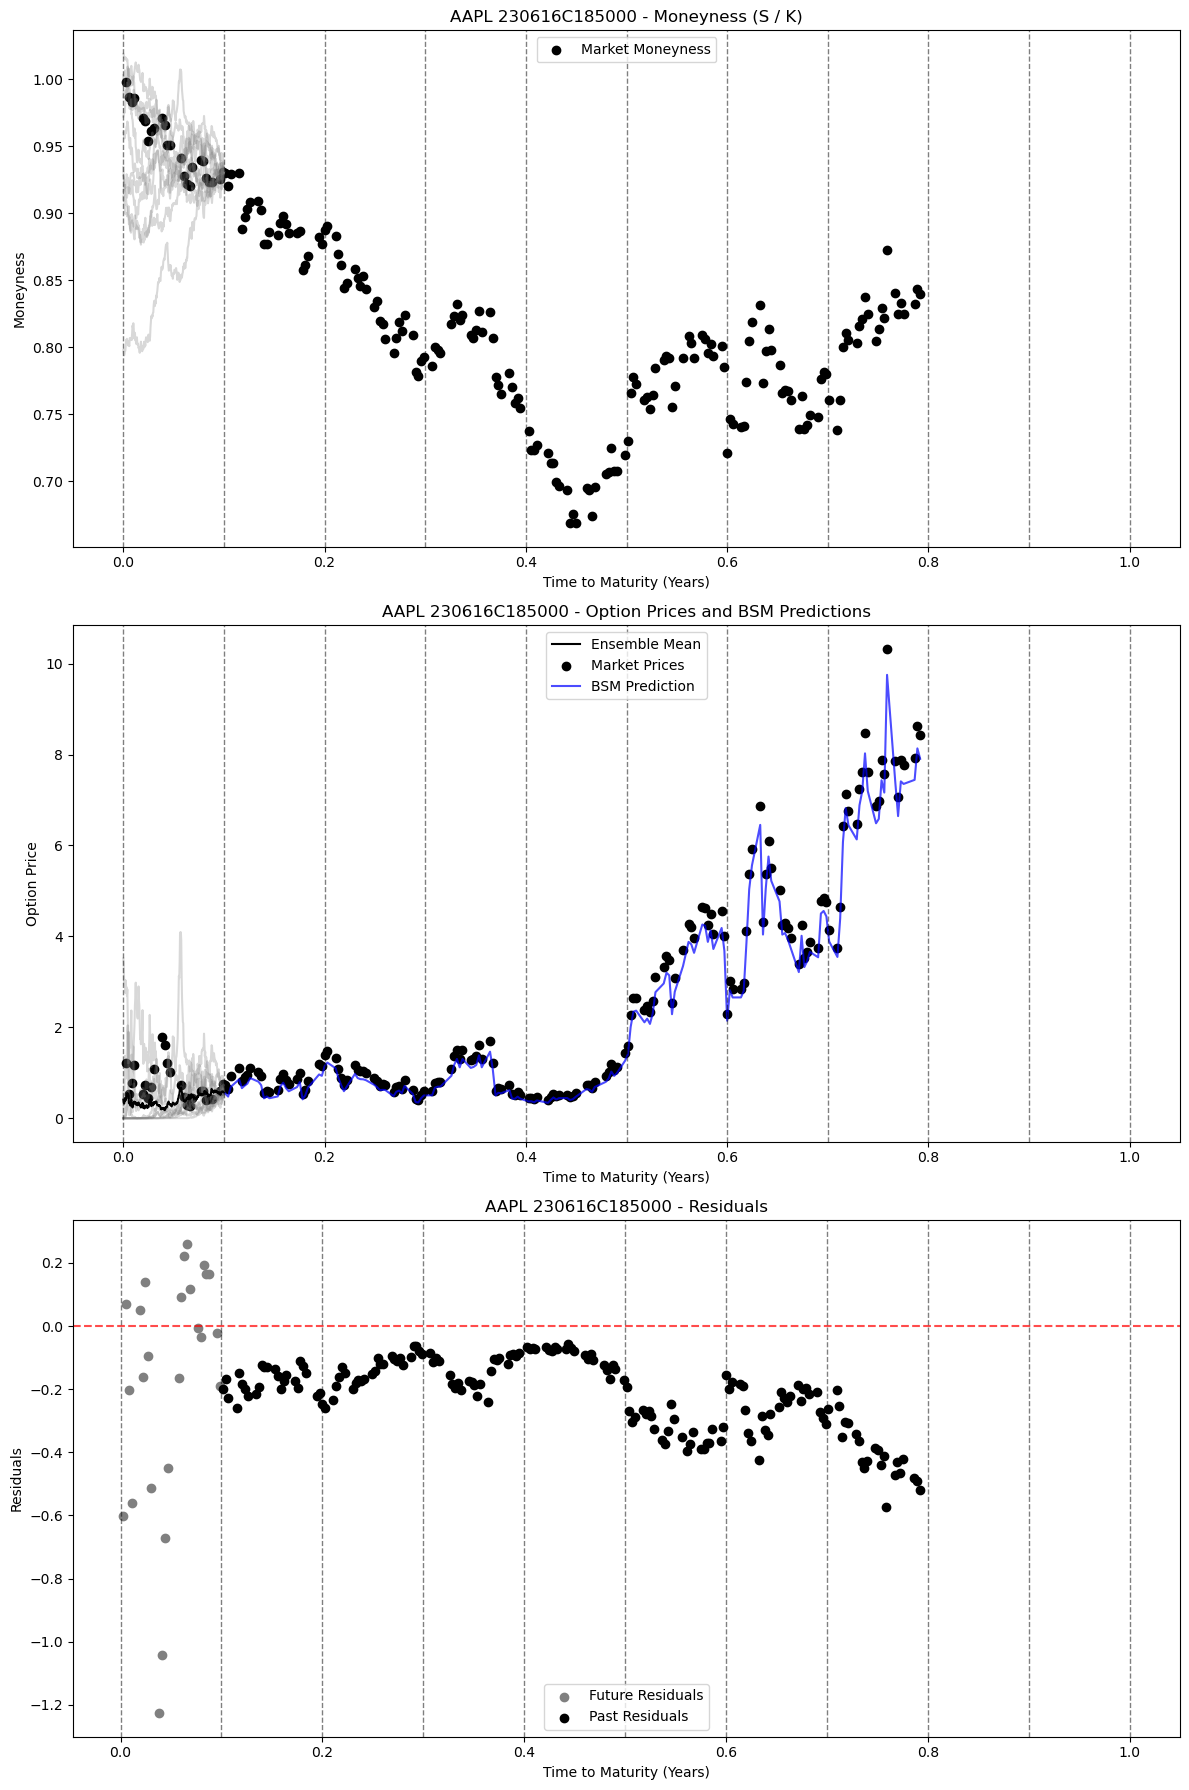


Generating plots for symbol: AAPL 230721C195000


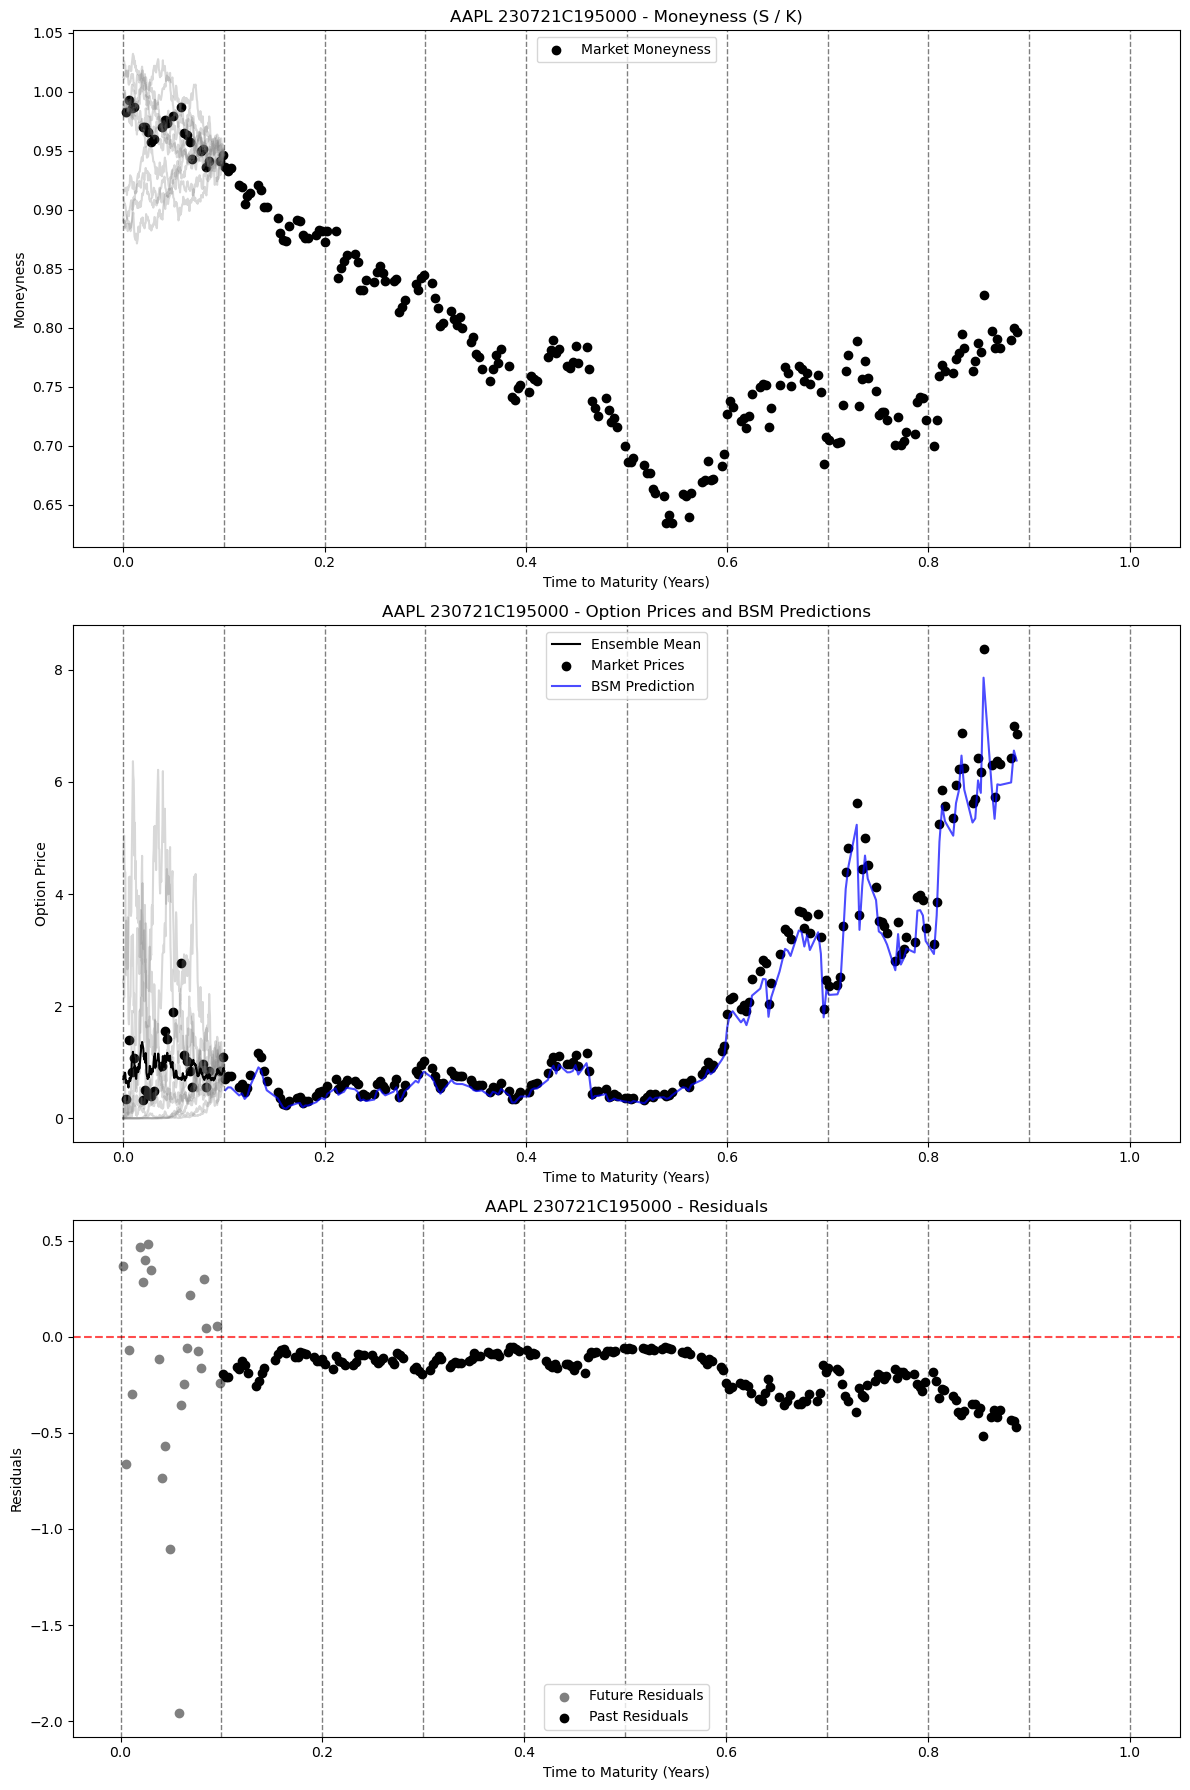


Generating plots for symbol: AAPL 230721C200000


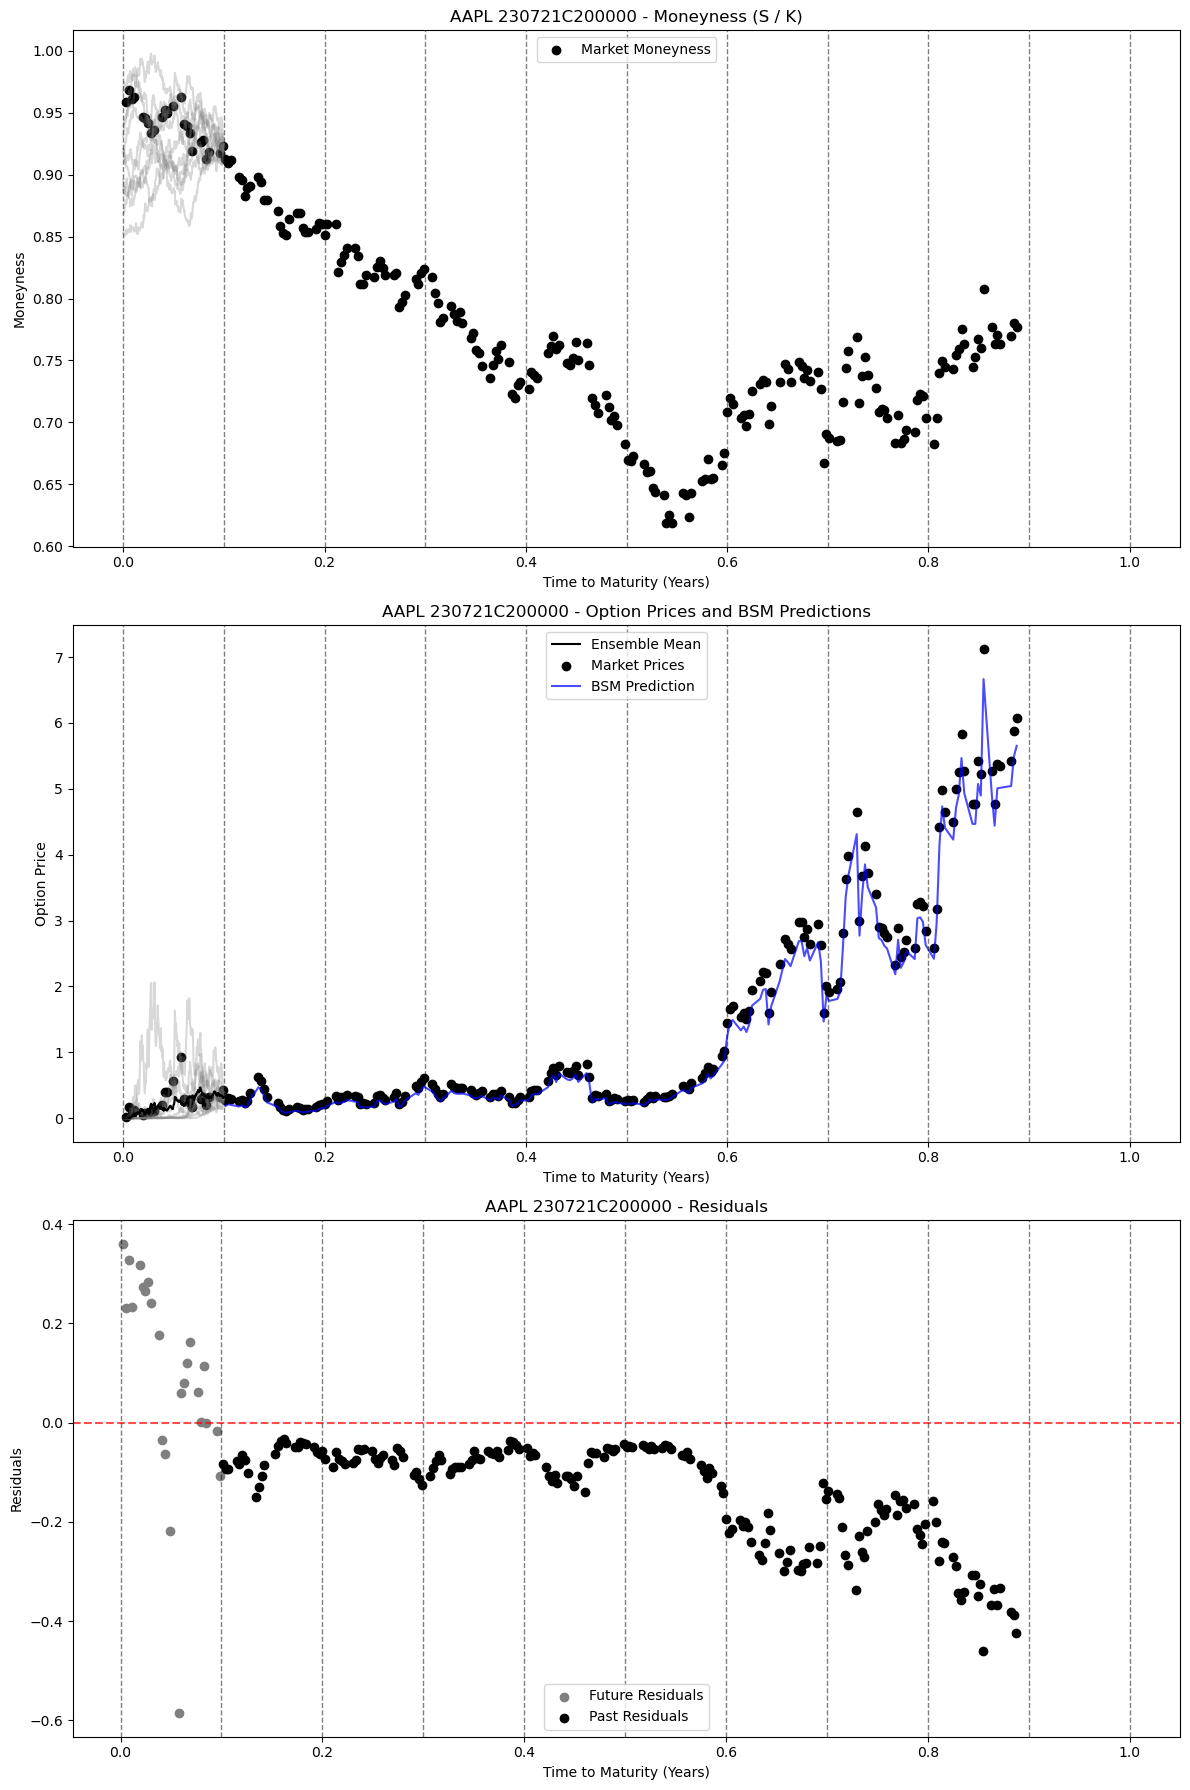

In [22]:
def main_processing(filtered_data):
    """
    Process the filtered data to extract top symbols, process each symbol,
    and generate initial plots.
    """
    # Simulation parameters
    simulation_params = {
        'n_steps': 252,
        'n_paths': 10,
        'early_fraction': 1 / 10
    }

    # Generate thresholds
    n_thresholds = 11
    thresholds = np.linspace(1, 0, n_thresholds)

    # Retrieve top 3 symbols based on trading volume
    top_symbols = get_top_symbols(filtered_data, top_n=3)
    print(f"Top {len(top_symbols)} symbols based on trading volume: {top_symbols}")

    # Filter data for the top symbols
    top_data = filtered_data[filtered_data["symbol"].isin(top_symbols)]

    # Dictionary to hold processed data for each symbol
    symbol_objects = {}

    # Process each symbol
    for symbol in top_symbols:
        print(f"\nProcessing symbol: {symbol}")
        symbol_specific_data = top_data[top_data["symbol"] == symbol]
        processed_data = process_symbol(symbol, symbol_specific_data, thresholds, simulation_params)
        symbol_objects[symbol] = processed_data

    # Plot data for each symbol
    for symbol, symbol_data in symbol_objects.items():
        print(f"\nGenerating plots for symbol: {symbol}")
        plot_symbol(symbol, symbol_data, thresholds)

    # Return the dictionary of processed symbols
    return symbol_objects





# Load and preprocess the data
filtered_data = load_and_preprocess_data("datacompr.csv")

# Execute the processing
symbol_objects = main_processing(filtered_data)

# Gaussian Process training


--- Gaussian Process Hyperparameter Tuning for AAPL 230616C185000 ---
Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV] END gp__alpha=0.0003727925903376984, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s[CV] END gp__alpha=0.0031489116479568604, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.9307782732027227, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s

[CV] END gp__alpha=0.07726718477963428, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.012561043700013555, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s
[CV] END gp__alpha=0.6993395623207707, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.014413469371110325, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.026926469100861772, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warn

[CV] END gp__alpha=0.17123375973163968, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.004938623547724716, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.16172900811143132, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.3s
[CV] END gp__alpha=0.011400863701127315, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.02680013555822697, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s
[CV] END gp__alpha=0.4569184576834543, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.024810409748678097, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.07004349545230058, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the boun

[CV] END gp__alpha=0.0008386394780402557, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.023184148549922887, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.06960678239135186, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0002701255772543907, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.00019777828512462716, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s
[CV] END gp__alpha=0.08111253665497056, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   2.0s
[CV] END gp__alpha=0.00010521761868451127, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.007742116473996243, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s
[CV] END gp__alpha=0.0015224209209544575, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0007477591721434688, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0004414536876494479, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.16973078532466998, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s
[CV] END gp__alpha=0.42394914738697626, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.3s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.017910276390244784, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   1.5s
[CV] END gp__alpha=0.008696007095406225, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0022410971619109504, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0770758077244593, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.0001817895809080395, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_co

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.0008226074946221035, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.5s
[CV] END gp__alpha=0.026161914205169598, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.8062316132568962, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0002407911195464457, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.7s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.001656246725411734, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0010165510266418728, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.16313946190943732, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a be

[CV] END gp__alpha=0.11129571947045998, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s
[CV] END gp__alpha=0.4295992790539123, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.00039115394960575025, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.0s
[CV] END gp__alpha=0.06991947034294088, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0007499924272398161, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.034207303670092254, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s
[CV] END gp__alpha=0.0051101206564971614, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   1.7s
[CV] END gp__alpha=0.0008207295819490817, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.013140210226207373, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.7272394089120149, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warn

[CV] END gp__alpha=0.03807949336768558, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s
[CV] END gp__alpha=0.06330402436741771, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0340726434853019, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.2s
[CV] END gp__alpha=0.5527642876529966, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.00035488184030109474, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=1

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0006859405588762045, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.1s
[CV] END gp__alpha=0.004149851045848952, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.0s
[CV] END gp__alpha=0.369986792048909, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.023097861492693564, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.9s
[CV] END gp__alpha=0.001707037915305904, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.4s
[CV] END gp__alpha=0.009925982828198463, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.03818468247973965, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.007581900067709791, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimi

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.0968201208688246, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.7s
[CV] END gp__alpha=0.002513701074476644, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.0s
[CV] END gp__alpha=0.0016702753704818105, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.008732116014759544, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.555416908302091, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
 

[CV] END gp__alpha=0.0001912777803308855, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.2481299452390813, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.7152863022216527, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.004776650059868051, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.44974071937498383, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.011839

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.009334064019986356, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.8s
[CV] END gp__alpha=0.00041702920189499705, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.002741350741975825, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s
[CV] END gp__alpha=0.15602015889668852, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.005674093553227242, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0019192001101561876, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=  11.3s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.002103784343227689, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=  11.3s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-0

[CV] END gp__alpha=0.00907425628898386, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=  15.1s
Best Parameters for GP: {'gp__alpha': 0.012561043700013555, 'gp__kernel': 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), 'gp__n_restarts_optimizer': 10, 'gp__optimizer': 'fmin_l_bfgs_b'}
Best Cross-Validated Neg MSE: -4.9922e-04
Validation MSE: 4.9922e-04
Validation R² Score: 0.7960


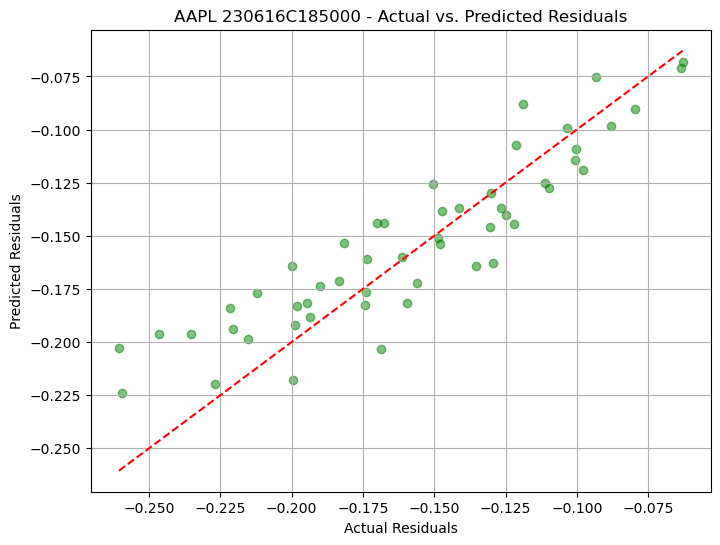

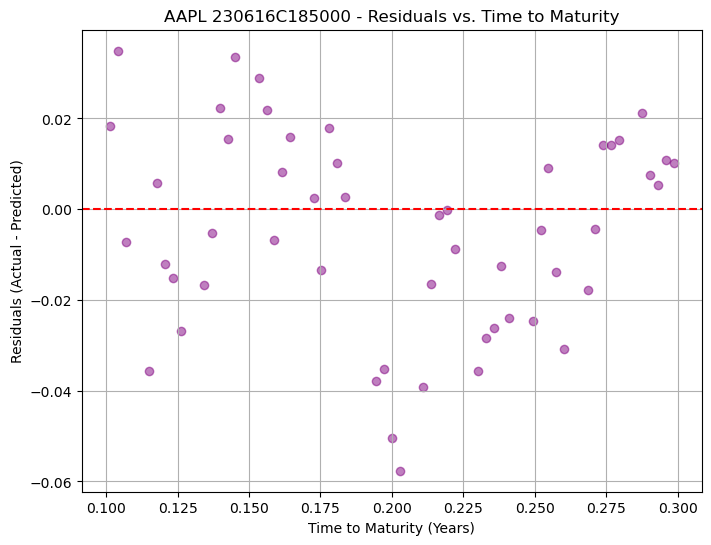

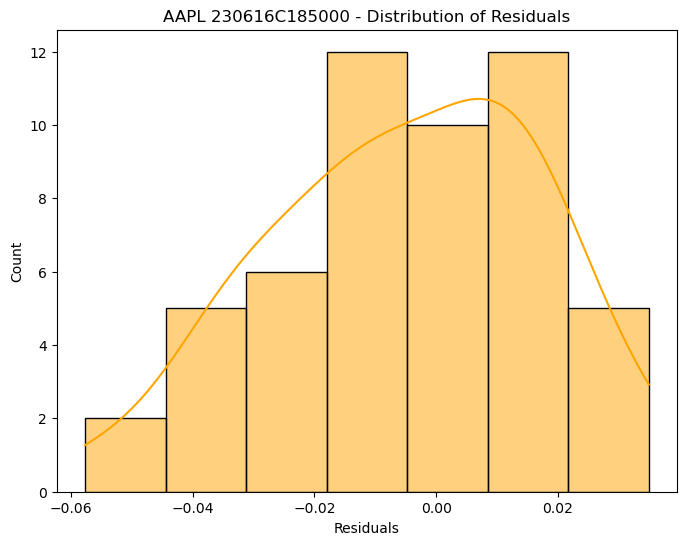

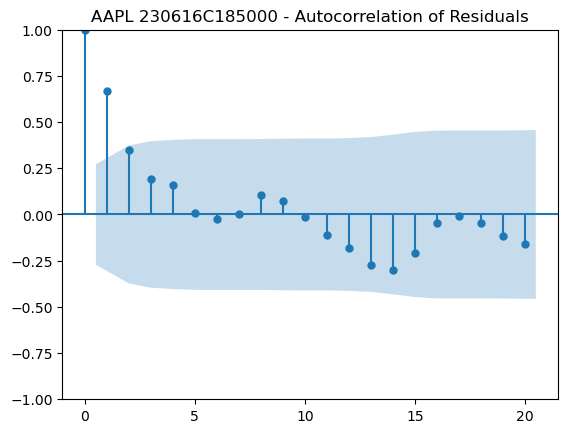

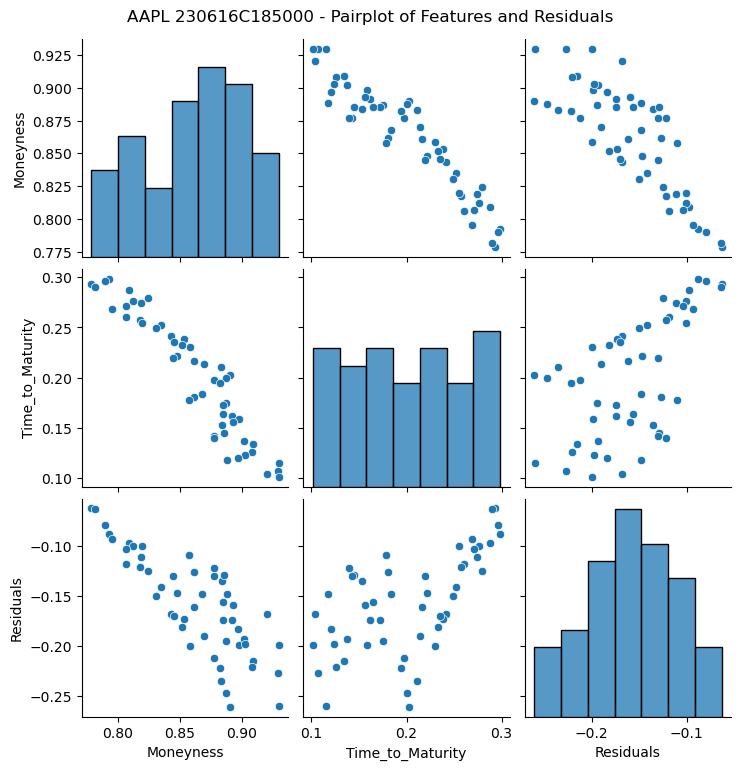

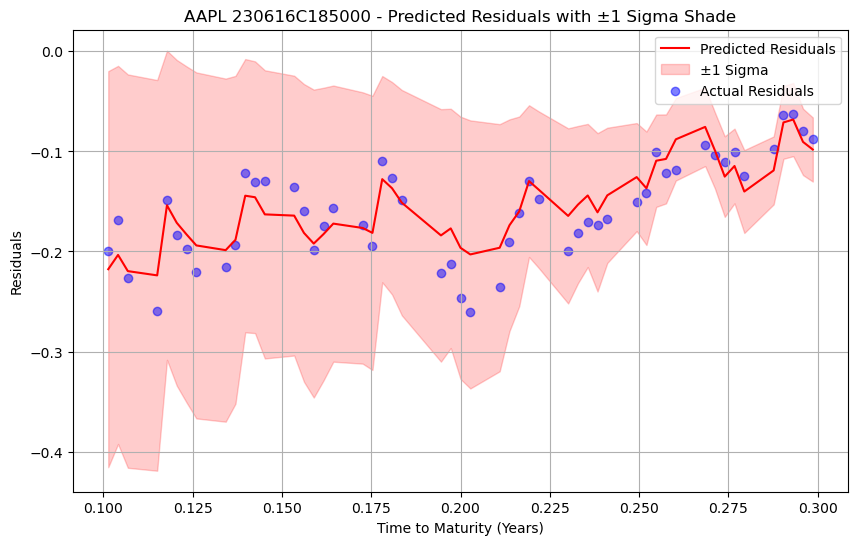


--- Gaussian Process Hyperparameter Tuning for AAPL 230721C195000 ---
Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV] END gp__alpha=0.0031489116479568604, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.00025113061677390004, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0003727925903376984, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.07726718477963428, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyl

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.012561043700013555, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s
[CV] END gp__alpha=0.6993395623207707, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.014413469371110325, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.026926469100861772, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.004938623547724716, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.17123375973163968, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.02680013555822697, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.6s
[CV] END gp__alpha=0.011400863701127315, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s
[CV] END gp__alpha=0.4569184576834543, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value

[CV] END gp__alpha=0.024810409748678097, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.07004349545230058, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s
[CV] END gp__alpha=0.16172900811143132, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
 

[CV] END gp__alpha=0.00010521761868451127, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.1s
[CV] END gp__alpha=0.0002701255772543907, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.023184148549922887, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.3s
[CV] END gp__alpha=0.0008386394780402557, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   2.9s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.08111253665497056, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   3.3s
[CV] END gp__alpha=0.00019777828512462716, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.8s
[CV] END gp__alpha=0.0007477591721434688, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.16973078532466998, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.0770758077244593, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.5s
[CV] END gp__alpha=0.06960678239135186, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0004414536876494479, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.0015224209209544575, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.42394914738697626, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.007742116473996243, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.1s
[CV] END gp__alpha=0.0001817895809080395, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.026161914205169598, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.2s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.017910276390244784, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.5s
[CV] END gp__alpha=0.001656246725411734, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.3s
[CV] END gp__alpha=0.008696007095406225, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0002407911195464457, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   4.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.0007499924272398161, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.9s
[CV] END gp__alpha=0.0008207295819490817, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.013140210226207373, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.7272394089120149, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.03807949336768558, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.0340726434853019, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s
[CV] END gp__alpha=0.06330402436741771, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.4295992790539123, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0051101206564971614, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.6s
[CV] END gp__alpha=0.784612724456642, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.05855726588796253, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.07058572590901788, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.00035488184030109474, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0008226074946221035, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.00039115394960575025, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.8062316132568962, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.004149851045848952, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.7s
[CV] END gp__alpha=0.5527642876529966, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0019192001101561876, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0006859405588762045, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.9s
[CV] END gp__alpha=0.009925982828198463, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.03818468247973965, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.007581900067709791, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.003024369161272647, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; tota

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.001707037915305904, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.1s
[CV] END gp__alpha=0.0968201208688246, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.9s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.002103784343227689, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   1.8s
[CV] END gp__alpha=0.0016702753704818105, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.008732116014759544, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.555416908302091, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.7152863022216527, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.3s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.023097861492693564, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   3.1s
[CV] END gp__alpha=0.06991947034294088, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.2481299452390813, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.009334064019986356, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   3.7s
[CV] END gp__alpha=0.004776650059868051, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, g

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
 

[CV] END gp__alpha=0.0001912777803308855, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.1s
[CV] END gp__alpha=0.002248954284391449, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.03510188772233665, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.1s
[CV] END gp__alpha=0.369986792048909, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.011839097834757692, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.00041702920189499705, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.002741350741975825, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.15602015889668852, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.002513701074476644, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.005674093553227242, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.3s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[CV] END gp__alpha=0.00010883991813938127, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=  20.1s
[CV] END gp__alpha=0.00907425628898386, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=  21.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better

[CV] END gp__alpha=0.11129571947045998, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s
[CV] END gp__alpha=0.16313946190943732, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
Best Parameters for GP: {'gp__alpha': 0.012561043700013555, 'gp__kernel': 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), 'gp__n_restarts_optimizer': 10, 'gp__optimizer': 'fmin_l_bfgs_b'}
Best Cross-Validated Neg MSE: -1.0146e-03
Validation MSE: 1.0146e-03
Validation R² Score: 0.4426


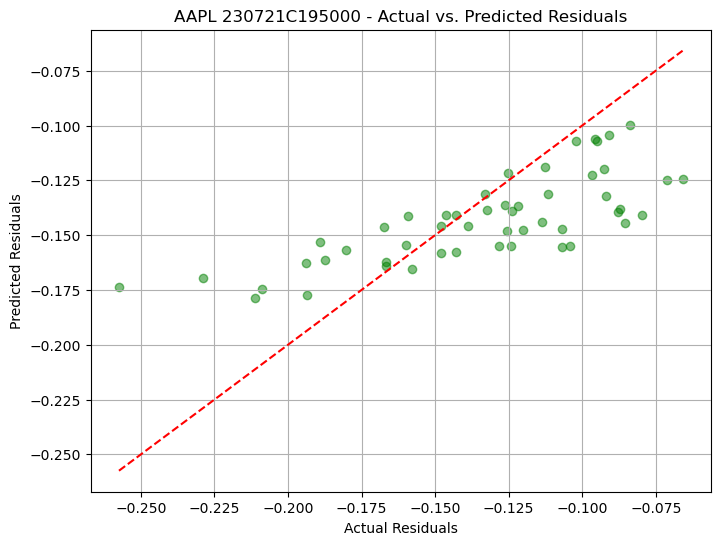

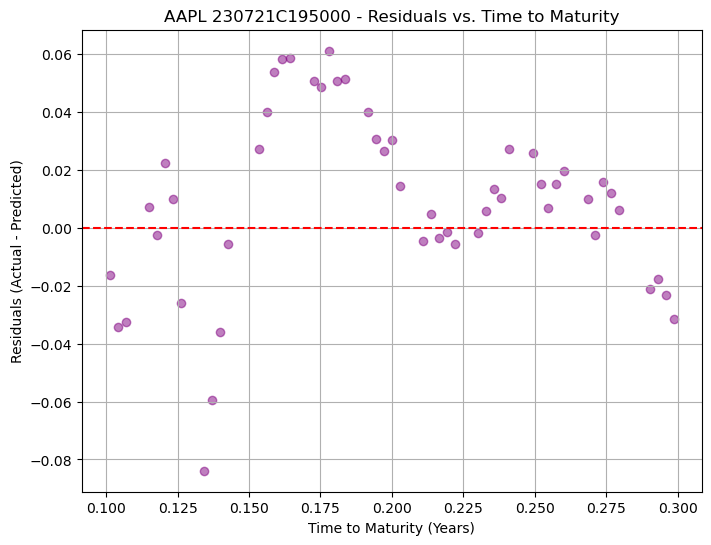

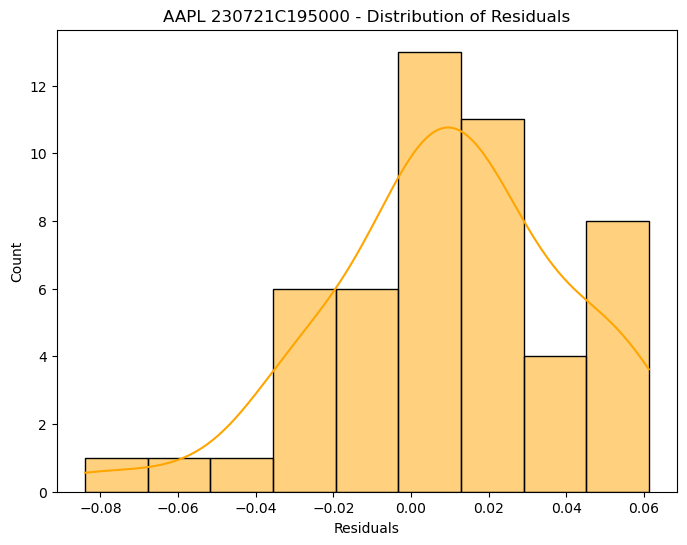

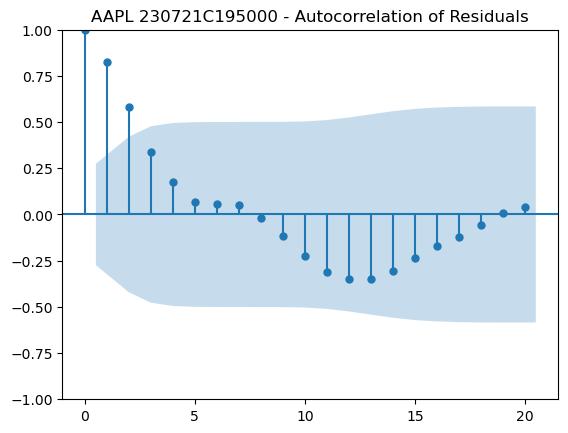

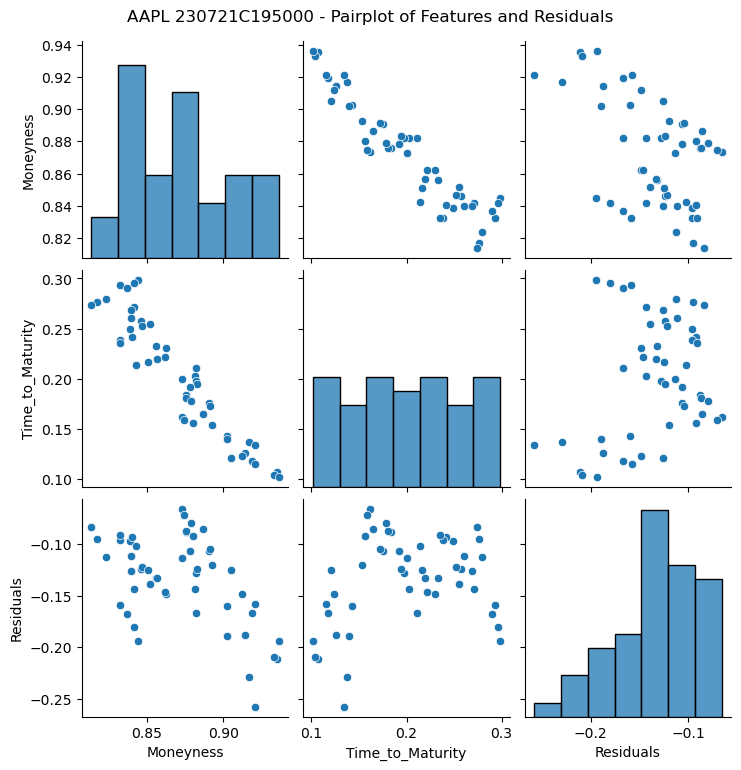

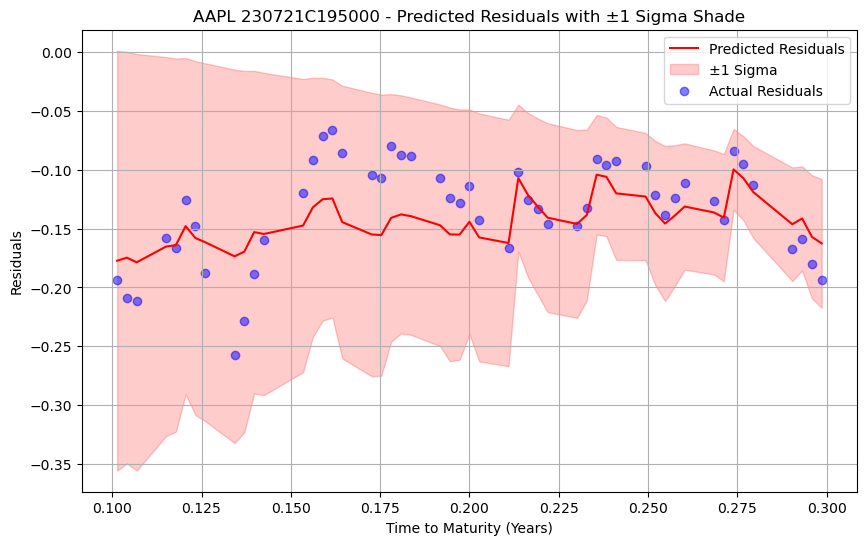


--- Gaussian Process Hyperparameter Tuning for AAPL 230721C200000 ---
Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV] END gp__alpha=0.0031489116479568604, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.00025113061677390004, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0003727925903376984, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.07726718477963428, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyl

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.012561043700013555, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s
[CV] END gp__alpha=0.6993395623207707, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.014413469371110325, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.17123375973163968, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.004938623547724716, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.026926469100861772, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.02680013555822697, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.011400863701127315, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s
[CV] END gp__alpha=0.4569184576834543, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.024810409748678097, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.07004349545230058, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.7s
[CV] END gp__alpha=0.16172900811143132, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.023184148549922887, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0008386394780402557, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   2.6s
[CV] END gp__alpha=0.0002701255772543907, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.00010521761868451127, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.00019777828512462716, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.08111253665497056, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   3.5s
[CV] END gp__alpha=0.0007477591721434688, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0004414536876494479, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.1s
[CV] END gp__alpha=0.0015224209209544575, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.16973078532466998, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.0770758077244593, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.8s
[CV] END gp__alpha=0.06960678239135186, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0022410971619109504, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.42394914738697626, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.007742116473996243, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.3s
[CV] END gp__alpha=0.0001817895809080395, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.017910276390244784, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.8s
[CV] END gp__alpha=0.026161914205169598, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.001656246725411734, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.4s
[CV] END gp__alpha=0.008696007095406225, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0002407911195464457, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   4.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0010165510266418728, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.0007499924272398161, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   2.2s
[CV] END gp__alpha=0.0008207295819490817, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.013140210226207373, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.7272394089120149, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.03807949336768558, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.4295992790539123, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.5s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0340726434853019, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.5s
[CV] END gp__alpha=0.06330402436741771, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.00035488184030109474, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.6s
[CV] END gp__alpha=0.0051101206564971614, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.9s
[CV] END gp__alpha=0.784612724456642, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.05855726588796253, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.07058572590901788, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimize

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.00039115394960575025, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.7s
[CV] END gp__alpha=0.8062316132568962, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0008226074946221035, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   2.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
 

[CV] END gp__alpha=0.00907425628898386, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.004149851045848952, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.5s
[CV] END gp__alpha=0.5527642876529966, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.00010883991813938127, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.4s
[CV] END gp__alpha=0.009925982828198463, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, g

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better valu

[CV] END gp__alpha=0.11129571947045998, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_l_bfgs_b; total time=   0.8s
[CV] END gp__alpha=0.16313946190943732, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.0016702753704818105, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.008732116014759544, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.555416908302091, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimiz

/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.001707037915305904, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.9s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.


[CV] END gp__alpha=0.0001912777803308855, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.7152863022216527, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.2s
[CV] END gp__alpha=0.2481299452390813, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0968201208688246, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   3.0s
[CV] END gp__alpha=0.004776650059868051, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.44974071937498383, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=10, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.011839097834757692, gp__kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   0.9s
[CV] END gp__alpha=0.002248954284391449, gp__kernel=1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_cobyla; total time=   0.0s
[CV] END gp__alpha=0.009334064019986356, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   3.1s
[CV] END gp__alpha=0.00041702920189499705, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
 

[CV] END gp__alpha=0.002103784343227689, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   2.7s
[CV] END gp__alpha=0.002741350741975825, gp__kernel=1**2 * RBF(length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=20, gp__optimizer=fmin_l_bfgs_b; total time=   1.5s
[CV] END gp__alpha=0.03510188772233665, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   1.9s
[CV] END gp__alpha=0.369986792048909, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.15602015889668852, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.4s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.0019192001101561876, gp__kernel=1**2 * ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=50, gp__optimizer=fmin_l_bfgs_b; total time=   5.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warni

[CV] END gp__alpha=0.002513701074476644, gp__kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.1s
[CV] END gp__alpha=0.005674093553227242, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_l_bfgs_b; total time=   1.8s


/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified upper bound 500.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/new_lubrication_env/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[CV] END gp__alpha=0.023097861492693564, gp__kernel=1**2 * RBF(length_scale=0.5) + Matern(length_scale=0.5, nu=0.5) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=40, gp__optimizer=fmin_l_bfgs_b; total time=   1.6s
[CV] END gp__alpha=0.06991947034294088, gp__kernel=1**2 * RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-06), gp__n_restarts_optimizer=30, gp__optimizer=fmin_cobyla; total time=   0.0s
Best Parameters for GP: {'gp__alpha': 0.012561043700013555, 'gp__kernel': 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06), 'gp__n_restarts_optimizer': 10, 'gp__optimizer': 'fmin_l_bfgs_b'}
Best Cross-Validated Neg MSE: -3.8830e-04
Validation MSE: 3.8830e-04
Validation R² Score: 0.3752


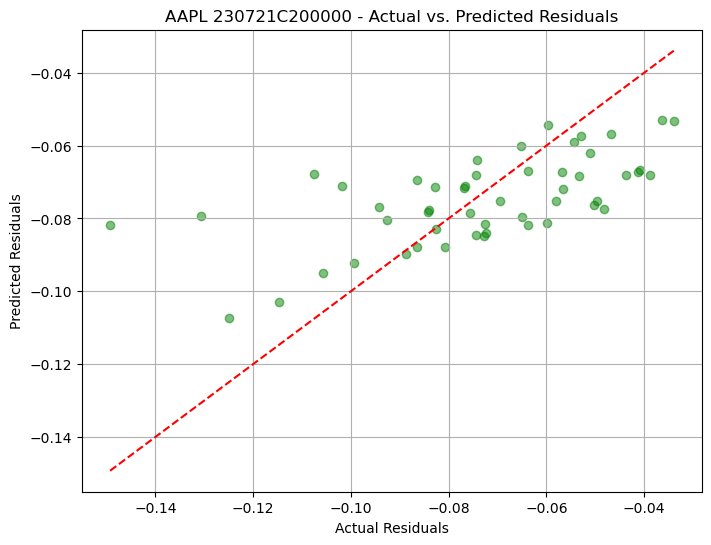

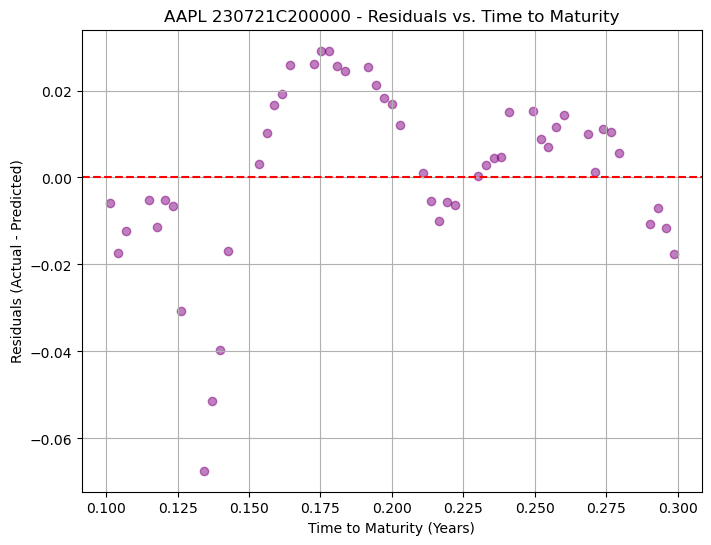

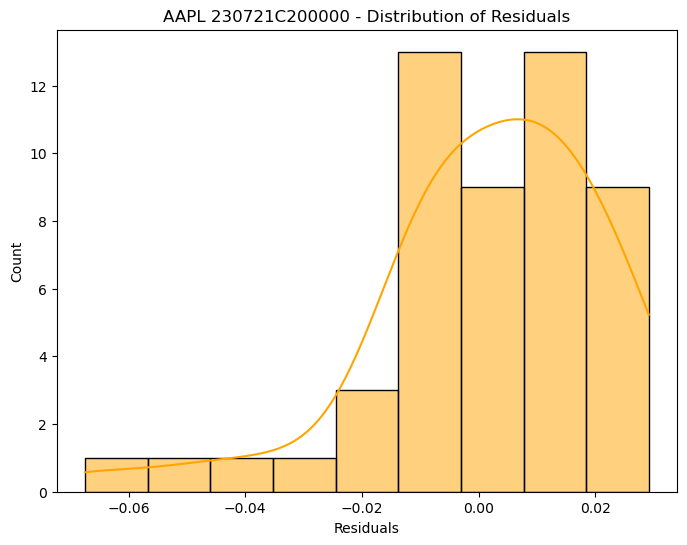

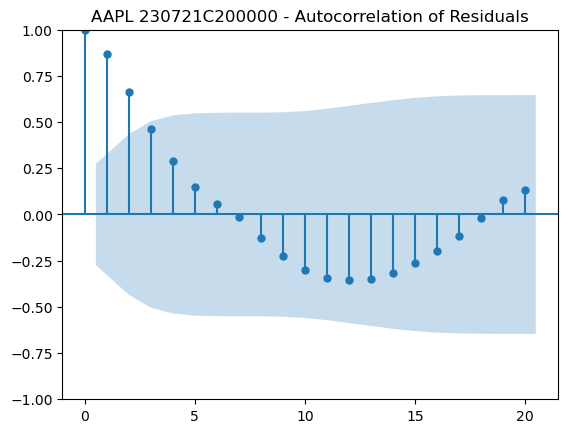

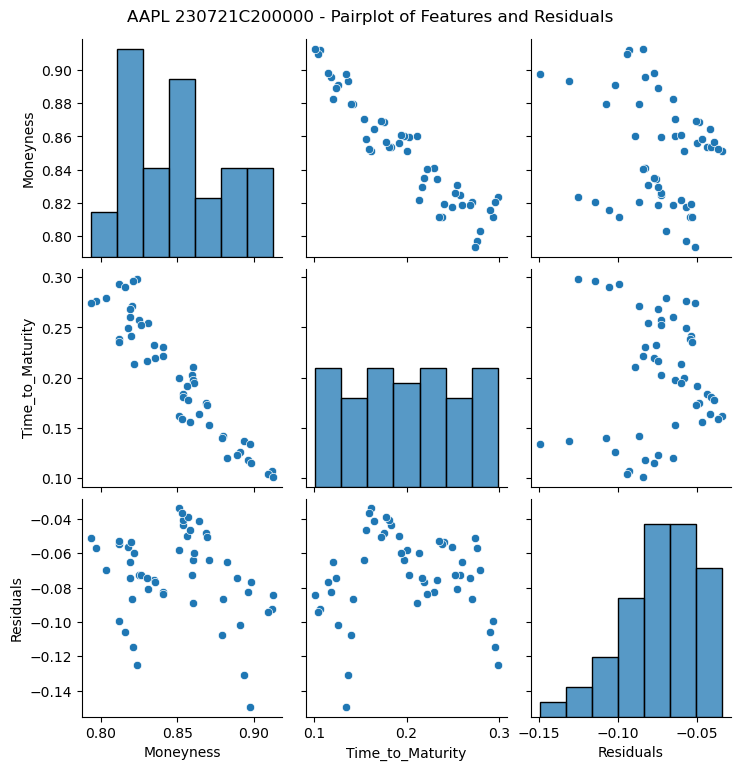

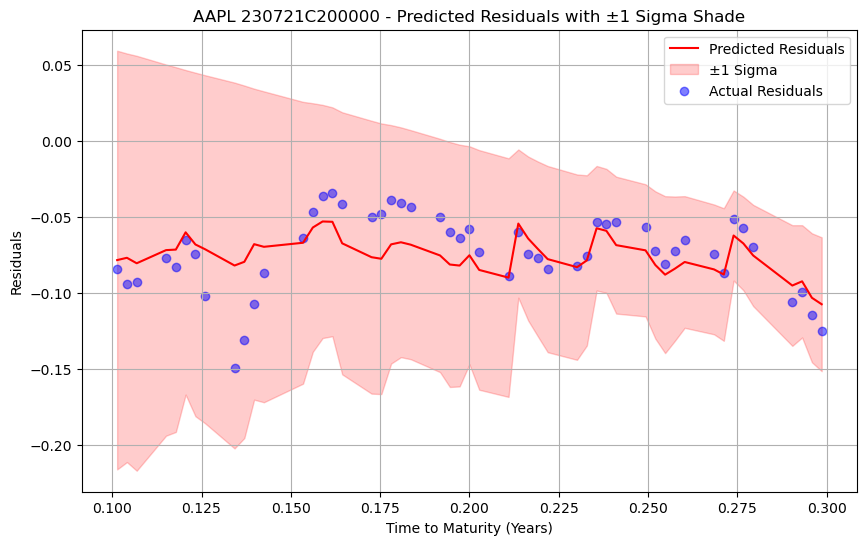


=== Summary of Best GP Hyperparameters for Each Symbol ===
            Symbol                                                                              Kernel    Alpha  n_restarts_optimizer     Optimizer  Validation MSE  Validation R²
AAPL 230616C185000 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06) 0.012561                    10 fmin_l_bfgs_b        0.000499       0.795978
AAPL 230721C195000 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06) 0.012561                    10 fmin_l_bfgs_b        0.001015       0.442555
AAPL 230721C200000 1**2 * DotProduct(sigma_0=1) + RBF(length_scale=1) + WhiteKernel(noise_level=1e-06) 0.012561                    10 fmin_l_bfgs_b        0.000388       0.375152

Summary table has been exported to 'gp_hyperparameters_summary.csv'.


In [23]:
# Cell 9: Enhanced Gaussian Processes Hyperparameter Tuning with Temporal Split and Advanced Settings

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, ConstantKernel as C, WhiteKernel,
    DotProduct, ExpSineSquared, RationalQuadratic
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd  # Ensure pandas is imported for the summary table
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

def gaussian_process_hyperparameter_tuning(symbol_objects):
    """
    Perform hyperparameter tuning for Gaussian Process Regression on each symbol,
    using a predefined training and validation split and advanced tuning techniques.

    Parameters:
        symbol_objects (dict): Dictionary containing OptionSymbolData objects for each symbol.

    Returns:
        None: Updates symbol_objects with the best GP model and metrics.
    """
    # Initialize a list to store best parameters for each symbol
    best_params_list = []

    for symbol, data in symbol_objects.items():
        print(f"\n--- Gaussian Process Hyperparameter Tuning for {symbol} ---")
        try:
            # Check if there are past residuals to train on
            if data.residuals_past is None:
                print("No past residuals to train on.")
                continue

            # Prepare data
            T = data.residuals_past[0]  # Time to Maturity
            residuals = data.residuals_past[1]  # Residuals
            moneyness = data.residuals_past_moneyness  # Moneyness

            # Define training (T > 0.3) and validation (0.1 < T <= 0.3) masks
            train_mask = T > 0.3
            val_mask = (T > 0.1) & (T <= 0.3)

            if not np.any(train_mask):
                print("No training data available with T > 0.3.")
                continue
            if not np.any(val_mask):
                print("No validation data available with 0.1 < T <= 0.3.")
                continue

            # Split the data
            X_train = np.column_stack((moneyness[train_mask], T[train_mask]))
            y_train = residuals[train_mask]

            X_val = np.column_stack((moneyness[val_mask], T[val_mask]))
            y_val = residuals[val_mask]

            # Combine training and validation data for PredefinedSplit
            X_combined = np.vstack((X_train, X_val))
            y_combined = np.hstack((y_train, y_val))

            # Create a split indicator: -1 for training, 0 for validation
            test_fold = np.hstack((
                -1 * np.ones(len(X_train), dtype=int),
                np.zeros(len(X_val), dtype=int)
            ))

            # Define PredefinedSplit
            ps = PredefinedSplit(test_fold=test_fold)

            # Define a pipeline with robust scaling and Gaussian Process
            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('gp', GaussianProcessRegressor(
                    optimizer='fmin_l_bfgs_b',
                    random_state=42
                ))
            ])

            # Define kernels with expanded lower bounds and additional kernel types
            composite_kernels = [
                C(1.0, (1e-5, 1e5)) * (
                    RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + 
                    Matern(length_scale=1.0, length_scale_bounds=(1e-3, 1e3), nu=1.5)
                ) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1)),
                
                C(1.0, (1e-5, 1e5)) * (
                    ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-3, 1e3), periodicity_bounds=(1e-3, 1e3))
                ) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1)),
                
                C(1.0, (1e-5, 1e5)) * (
                    RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-3, 1e3), alpha_bounds=(1e-3, 1e3))
                ) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1))
            ]

            kernels = [
                C(1.0, (1e-5, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + 
                WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1)),
                
                C(1.0, (1e-5, 1e5)) * Matern(length_scale=1.0, 
                                            length_scale_bounds=(1e-3, 1e3), 
                                            nu=1.5) + 
                WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1)),
                
                # Composite kernel 1
                C(1.0, (1e-5, 1e5)) * (
                    RBF(length_scale=0.5, length_scale_bounds=(1e-4, 5e2)) + 
                    Matern(length_scale=0.5, length_scale_bounds=(1e-4, 5e2), nu=0.5)
                ) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1)),
                
                # Composite kernel 2
                C(1.0, (1e-5, 1e5)) * (
                    DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-3, 1e3)) + 
                    RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))
                ) + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-6, 1e1))
            ]

            # Combine all kernels
            all_kernels = kernels + composite_kernels

            # Define parameter grid for RandomizedSearchCV with expanded lower bounds
            param_dist = {
                'gp__kernel': all_kernels,
                #increase the lower bound to force the models to have more uncertainty
                'gp__alpha': loguniform(1e-4, 1e0),  # Log-uniform distribution for alpha
                'gp__n_restarts_optimizer': [10, 20, 30, 40, 50],
                'gp__optimizer': ['fmin_l_bfgs_b', 'fmin_cobyla']  # Explore different optimizers
            }

            # Initialize RandomizedSearchCV with PredefinedSplit
            random_search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_dist,
                n_iter=100,  # Increased number of iterations for broader exploration
                cv=ps,  # Use PredefinedSplit
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=2,  # Increased verbosity for better tracking
                random_state=42,
                refit=False  # Prevent automatic refitting on the entire dataset
            )

            # Fit RandomizedSearchCV on combined data
            random_search.fit(X_combined, y_combined)

            # Retrieve the best parameters based on validation set performance
            best_params = random_search.best_params_
            best_score = random_search.best_score_  # This is the mean cross-validated score of the best_estimator
            print(f"Best Parameters for GP: {best_params}")
            print(f"Best Cross-Validated Neg MSE: {best_score:.4e}")

            # Append best parameters to the list for the summary table
            best_params_list.append({
                'Symbol': symbol,
                'Kernel': str(best_params['gp__kernel']),
                'Alpha': best_params['gp__alpha'],
                'n_restarts_optimizer': best_params['gp__n_restarts_optimizer'],
                'Optimizer': best_params['gp__optimizer'],
                'Validation MSE': None,  # Placeholder to be updated later
                'Validation R²': None     # Placeholder to be updated later
            })

            # Manually train the best model on the training set only
            # Extract the kernel parameter
            best_kernel = best_params['gp__kernel']
            best_alpha = best_params['gp__alpha']
            best_n_restarts = best_params['gp__n_restarts_optimizer']
            best_optimizer = best_params['gp__optimizer']

            # Define the best GP regressor with the best hyperparameters
            best_gp = GaussianProcessRegressor(
                kernel=best_kernel,
                alpha=best_alpha,
                n_restarts_optimizer=best_n_restarts,
                optimizer=best_optimizer,
                random_state=42
            )

            # Create a new pipeline for the best model
            best_pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('gp', best_gp)
            ])

            # Fit the best pipeline on the training data only
            best_pipeline.fit(X_train, y_train)

            # Update symbol_data with the best GP model and parameters
            data.model = best_pipeline
            data.gp_best_params = best_params

            # Evaluate on validation set
            y_val_pred, y_val_std = best_pipeline.predict(X_val, return_std=True)

            # Compute metrics on validation set
            mse_val = mean_squared_error(y_val, y_val_pred)
            r2_val = r2_score(y_val, y_val_pred)

            print(f"Validation MSE: {mse_val:.4e}")
            print(f"Validation R² Score: {r2_val:.4f}")

            # Update the last entry in best_params_list with the actual metrics
            best_params_list[-1]['Validation MSE'] = mse_val
            best_params_list[-1]['Validation R²'] = r2_val

            # Store metrics in the data object
            data.mse = mse_val
            data.r2 = r2_val

            # Diagnostic Visualizations

            # a. Actual vs Predicted Residuals
            plt.figure(figsize=(8, 6))
            plt.scatter(y_val, y_val_pred, alpha=0.5, color='green')
            plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
            plt.xlabel('Actual Residuals')
            plt.ylabel('Predicted Residuals')
            plt.title(f'{symbol} - Actual vs. Predicted Residuals')
            plt.grid(True)
            plt.show()

            # b. Residuals vs. Time to Maturity
            residuals = y_val - y_val_pred
            plt.figure(figsize=(8, 6))
            plt.scatter(X_val[:, 1], residuals, alpha=0.5, color='purple')
            plt.axhline(0, color='red', linestyle='--')
            plt.xlabel('Time to Maturity (Years)')
            plt.ylabel('Residuals (Actual - Predicted)')
            plt.title(f'{symbol} - Residuals vs. Time to Maturity')
            plt.grid(True)
            plt.show()

            # c. Histogram of Residuals
            plt.figure(figsize=(8, 6))
            sns.histplot(residuals, kde=True, color='orange')
            plt.xlabel('Residuals')
            plt.title(f'{symbol} - Distribution of Residuals')
            plt.show()

            # d. Autocorrelation of Residuals
            from statsmodels.graphics.tsaplots import plot_acf
            plot_acf(residuals, lags=20)
            plt.title(f'{symbol} - Autocorrelation of Residuals')
            plt.show()

            # e. Pairplot for Feature Relationships
            df_val = pd.DataFrame({
                'Moneyness': X_val[:, 0],
                'Time_to_Maturity': X_val[:, 1],
                'Residuals': y_val
            })
            sns.pairplot(df_val)
            plt.suptitle(f'{symbol} - Pairplot of Features and Residuals', y=1.02)
            plt.show()

            # f. Predicted Residuals with ±1 Sigma Shade
            plt.figure(figsize=(10, 6))
            plt.plot(X_val[:, 1], y_val_pred, label='Predicted Residuals', color='red')  # Red line
            plt.fill_between(
                X_val[:, 1],
                y_val_pred - y_val_std,
                y_val_pred + y_val_std,
                color='red',  # Red shade
                alpha=0.2,
                label='±1 Sigma'
            )
            plt.scatter(X_val[:, 1], y_val, color='blue', alpha=0.5, label='Actual Residuals')  # Blue scatter
            plt.xlabel('Time to Maturity (Years)')
            plt.ylabel('Residuals')
            plt.title(f'{symbol} - Predicted Residuals with ±1 Sigma Shade')
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"An error occurred during GP tuning for {symbol}: {e}")

    # After processing all symbols, create and display the summary table
    if best_params_list:
        summary_df = pd.DataFrame(best_params_list)
        print("\n=== Summary of Best GP Hyperparameters for Each Symbol ===")
        print(summary_df.to_string(index=False))
        
        # Optional: Export the summary table to a CSV file for reporting
        summary_df.to_csv('gp_hyperparameters_summary.csv', index=False)
        print("\nSummary table has been exported to 'gp_hyperparameters_summary.csv'.")
    else:
        print("\nNo symbols were processed. Please check your data and preprocessing steps.")

# Execute Gaussian Process hyperparameter tuning with the enhanced function
gaussian_process_hyperparameter_tuning(symbol_objects)


--- Evaluating and Visualizing GP Predictions for AAPL 230616C185000 ---

Segment 1:
BSM Validation MSE: 8.8477e-02
BSM Validation R² Score: 0.4146
BSM + GP Validation MSE: 2.0009e-02
BSM + GP Validation R² Score: 0.8676


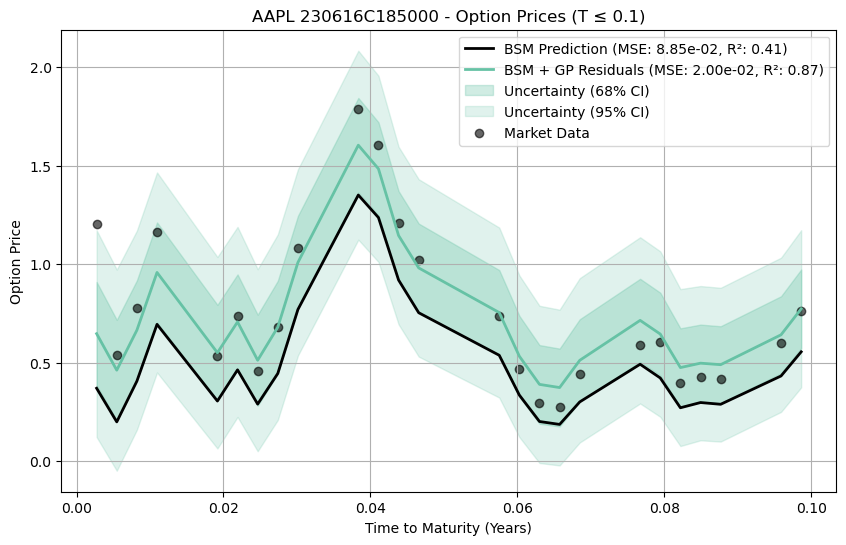

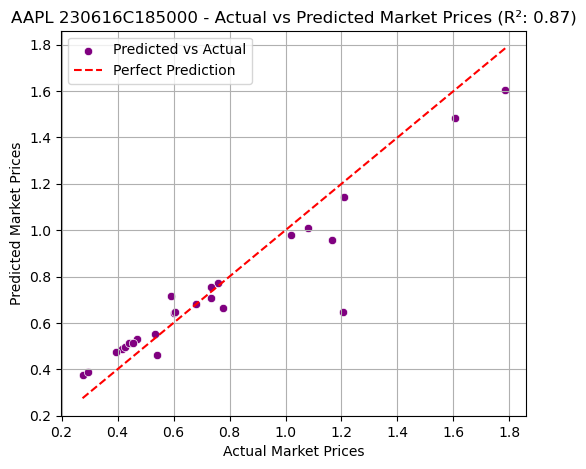

R² Score for AAPL 230616C185000 (GP Residuals): 0.8676

--- Evaluating and Visualizing GP Predictions for AAPL 230721C195000 ---

Segment 1:
BSM Validation MSE: 1.2536e-01
BSM Validation R² Score: 0.5831
BSM + GP Validation MSE: 3.6759e-02
BSM + GP Validation R² Score: 0.8777


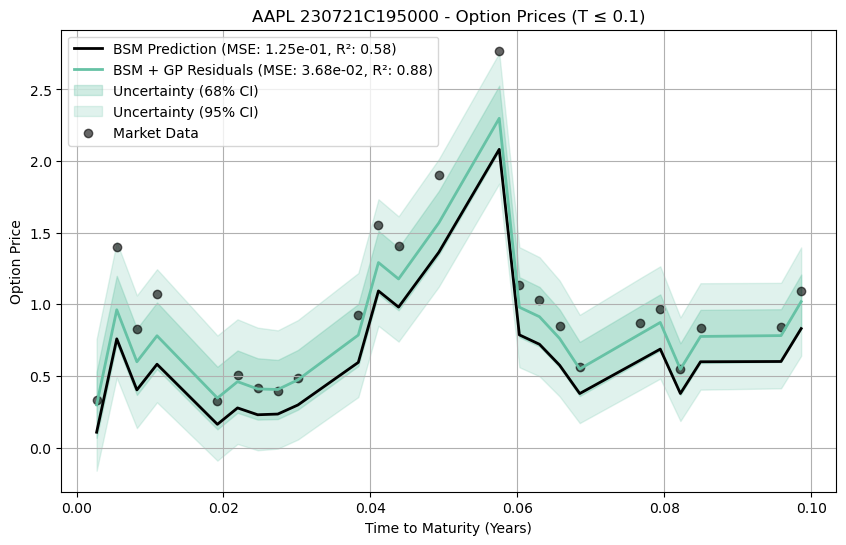

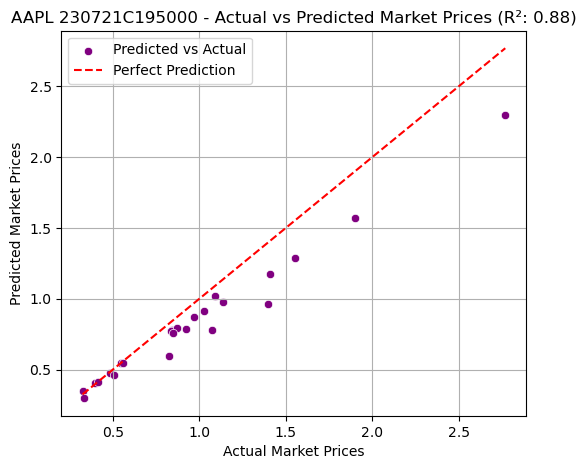

R² Score for AAPL 230721C195000 (GP Residuals): 0.8777

--- Evaluating and Visualizing GP Predictions for AAPL 230721C200000 ---

Segment 1:
BSM Validation MSE: 1.3187e-02
BSM Validation R² Score: 0.6553
BSM + GP Validation MSE: 3.3078e-03
BSM + GP Validation R² Score: 0.9135


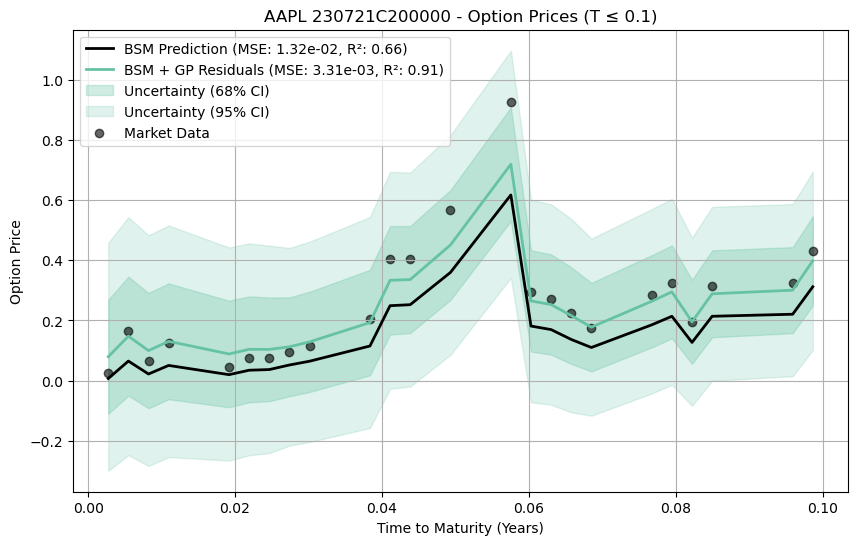

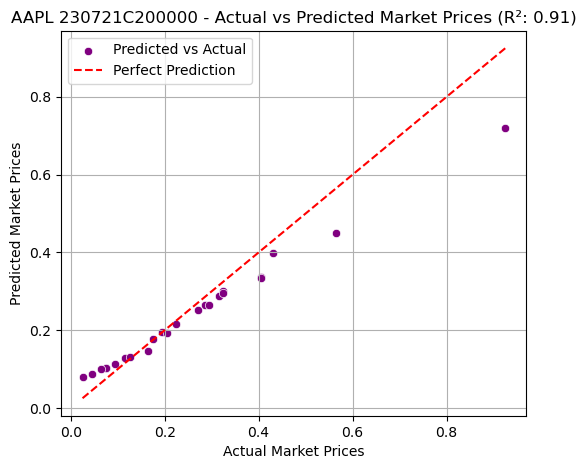

R² Score for AAPL 230721C200000 (GP Residuals): 0.9135


In [24]:
# Cell 2: Evaluation and Visualization of GP Predictions with R² Scores in Labels

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_and_visualize_gp_predictions(symbol_objects):
    """
    Predict residuals for T <= 0.1 using the trained GP models, adjust BSM predictions,
    compute separate MSEs and R² scores for BSM and BSM + GP residuals, and visualize the results.

    Parameters:
        symbol_objects (dict): Dictionary containing OptionSymbolData objects for each symbol.

    Returns:
        None
    """
    for symbol, data in symbol_objects.items():
        print(f"\n--- Evaluating and Visualizing GP Predictions for {symbol} ---")
        try:
            # Check if GP model is trained
            if data.model is None:
                print("No trained GP model found.")
                continue

            # Check if there are future residuals to predict
            if not hasattr(data, 'sim_residuals_future') or not data.sim_residuals_future:
                print("No future residuals to predict.")
                continue

            # Iterate over each future residuals segment (if multiple exist)
            for idx, (time_tm, residuals_future) in enumerate(data.sim_residuals_future):
                print(f"\nSegment {idx+1}:")

                # Extract corresponding features for prediction
                mask_future = data.market_time_to_maturity <= 0.1
                moneyness_future = data.market_moneyness[mask_future]
                T_future = data.market_time_to_maturity[mask_future]
                BSM_future = data.BSM_prices[mask_future]
                Market_actual = data.market_option_prices[mask_future]

                if len(T_future) == 0:
                    print("No data points with T <= 0.1 in this segment.")
                    continue

                # Prepare features for prediction
                X_future = np.column_stack((moneyness_future, T_future))

                # Predict residuals and uncertainty using the trained pipeline
                y_pred, y_std = data.model.predict(X_future, return_std=True)

                # Adjust BSM predictions with predicted residuals
                # Assuming residuals = BSM_pred - Market_actual
                Market_pred = BSM_future - y_pred  # Adjusted prediction

                # Compute loss metrics for BSM Prediction
                mse_bsm = mean_squared_error(Market_actual, BSM_future)
                r2_bsm = r2_score(Market_actual, BSM_future)

                # Compute loss metrics for BSM + GP Residuals
                mse_gp = mean_squared_error(Market_actual, Market_pred)
                r2_gp = r2_score(Market_actual, Market_pred)

                print(f"BSM Validation MSE: {mse_bsm:.4e}")
                print(f"BSM Validation R² Score: {r2_bsm:.4f}")
                print(f"BSM + GP Validation MSE: {mse_gp:.4e}")
                print(f"BSM + GP Validation R² Score: {r2_gp:.4f}")

                # Plotting
                plt.figure(figsize=(10,6))

                # Plot BSM Prediction with MSE and R² in label
                plt.plot(
                    T_future,
                    BSM_future,
                    label=f'BSM Prediction (MSE: {mse_bsm:.2e}, R²: {r2_bsm:.2f})',
                    color='black',
                    linewidth=2
                )

                # Plot BSM + GP Residuals with MSE and R² in label
                plt.plot(
                    T_future,
                    Market_pred,
                    label=f'BSM + GP Residuals (MSE: {mse_gp:.2e}, R²: {r2_gp:.2f})',
                    color='#66c2a5',  # Gentle green
                    linewidth=2
                )

                # Shaded Uncertainty: 68% and 95%
                plt.fill_between(
                    T_future,
                    Market_pred - y_std,
                    Market_pred + y_std,
                    color='#66c2a5',
                    alpha=0.3,
                    label='Uncertainty (68% CI)'
                )

                plt.fill_between(
                    T_future,
                    Market_pred - 2*y_std,
                    Market_pred + 2*y_std,
                    color='#66c2a5',
                    alpha=0.2,
                    label='Uncertainty (95% CI)'
                )

                # Scatter plot of Actual Market Prices
                plt.scatter(
                    T_future,
                    Market_actual,
                    label='Market Data',
                    color='black',
                    alpha=0.6
                )

                plt.xlabel("Time to Maturity (Years)")
                plt.ylabel("Option Price")
                plt.title(f"{symbol} - Option Prices (T ≤ 0.1)")
                plt.legend()
                plt.grid(True)
                plt.show()

                # Plot Actual vs Predicted Market Prices with R² in title
                plt.figure(figsize=(6,5))
                sns.scatterplot(x=Market_actual, y=Market_pred, color='purple', label='Predicted vs Actual')
                plt.plot([Market_actual.min(), Market_actual.max()], 
                         [Market_actual.min(), Market_actual.max()], 'r--', label='Perfect Prediction')
                plt.xlabel("Actual Market Prices")
                plt.ylabel("Predicted Market Prices")
                plt.title(f"{symbol} - Actual vs Predicted Market Prices (R²: {r2_gp:.2f})")
                plt.legend()
                plt.grid(True)
                plt.show()

                # Print R² Score
                print(f"R² Score for {symbol} (GP Residuals): {r2_gp:.4f}")

        except Exception as e:
            print(f"An error occurred during evaluation for {symbol}: {e}")

# Execute evaluation and visualization
evaluate_and_visualize_gp_predictions(symbol_objects)

In [25]:
#Extract and Print Trained Kernel Parameters for All Symbols

print("=== Extracting Trained Kernel Parameters for Each Symbol ===")

# Loop over all symbols and their trained models
for symbol, data in symbol_objects.items():
    print(f"\n--- {symbol} ---")
    try:
        # Check if a GP model exists
        if data.model is None:
            print("No trained GP model found.")
            continue
        
        # Access the trained Gaussian Process Regressor from the pipeline
        gp_model = data.model.named_steps['gp']
        
        # Get the optimized kernel
        optimized_kernel = gp_model.kernel_
        print(f"Trained Kernel: {optimized_kernel}")
        
        # Extract and print the kernel parameters
        kernel_params = optimized_kernel.get_params()
        print("Extracted Kernel Parameters:")
        for param, value in kernel_params.items():
            print(f"  {param}: {value}")
        
        # Optionally, store the extracted parameters in the data object
        data.kernel_parameters = kernel_params
        
    except Exception as e:
        print(f"An error occurred while extracting parameters for {symbol}: {e}")

=== Extracting Trained Kernel Parameters for Each Symbol ===

--- AAPL 230616C185000 ---
Trained Kernel: 0.109**2 * DotProduct(sigma_0=1.95) + RBF(length_scale=1.07) + WhiteKernel(noise_level=1e-06)
Extracted Kernel Parameters:
  k1: 0.109**2 * DotProduct(sigma_0=1.95) + RBF(length_scale=1.07)
  k2: WhiteKernel(noise_level=1e-06)
  k1__k1: 0.109**2
  k1__k2: DotProduct(sigma_0=1.95) + RBF(length_scale=1.07)
  k1__k1__constant_value: 0.011859377125231009
  k1__k1__constant_value_bounds: (1e-05, 100000.0)
  k1__k2__k1: DotProduct(sigma_0=1.95)
  k1__k2__k2: RBF(length_scale=1.07)
  k1__k2__k1__sigma_0: 1.94719354305642
  k1__k2__k1__sigma_0_bounds: (0.001, 1000.0)
  k1__k2__k2__length_scale: 1.066787023259381
  k1__k2__k2__length_scale_bounds: (0.001, 1000.0)
  k2__noise_level: 1.0000000000000004e-06
  k2__noise_level_bounds: (1e-06, 10.0)

--- AAPL 230721C195000 ---
Trained Kernel: 0.109**2 * DotProduct(sigma_0=1.49) + RBF(length_scale=1.43) + WhiteKernel(noise_level=1e-06)
Extracted Ke